# Praca domowa 4 - Wstęp do Uczenia Maszynowego
## Maja Andrzejczuk i Julia Przybytniowska

In [59]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Korzystając z pracy domowej 3 przeprowadzimy preprocessing danych, aby modele oraz ich tuning były bardziej efektywne:
- sprawdzenie unikatowych wartości w kolumnach o zmiennych *int*, usunięcie niepotrzebnych
- zamiana wartości odstających (2,5%, 97,5%) na wartości w tych kwantylach
- zmiana kierunku korelacji na dodatni
- normalizacja zmiennych ciągłych przy użyciu MinMaxScaler()
- podział danych na zbiór treningowy i testowy

Przeprowadzimy to w jednej komórce ze względu na fakt że jest to powtórzenie kodu z wcześniejszego zadania.

In [61]:
#for col in df:
#  if len(df[col].unique()) < 100:
#    print(df[col].unique(), col)
#df[' Liability-Assets Flag'].value_counts()
#df[' Net Income Flag'].value_counts()
df.drop(columns = [' Liability-Assets Flag',' Net Income Flag'], inplace = True)
df_train,df_val = train_test_split(df,test_size=0.3, random_state=420, stratify=df['Bankrupt?'])

def outliers_to_quantiles(df):
    up_quantiles = df.quantile(0.975,axis=0)
    down_quantiles = df.quantile(0.025,axis=0)
    outliers_low = (df < down_quantiles)
    outliers_high = (df > up_quantiles)
    df_train = df.where(~outliers_low, down_quantiles, axis=1)
    df_train = df.where(~outliers_high, up_quantiles, axis=1)
    return df

def make_corr_positive(df):
  corrs = df.corrwith(df['Bankrupt?'])
  neg_corrs = np.where(corrs < 0)
  df.iloc[:,neg_corrs[0].tolist()] = -df.iloc[:,neg_corrs[0].tolist()]
  return df

def normalize_and_split(df):
  X = df.drop(columns = ['Bankrupt?'])  #zmienne opisujące, które będą normalizowane
  Y = df['Bankrupt?']                  #zmienna celu
  X = MinMaxScaler().fit_transform(X)
  return train_test_split(X, Y, test_size=0.3, random_state=420, stratify=Y)

df_train = outliers_to_quantiles(df_train)
df_train = make_corr_positive(df_train)
X_train, X_test, y_train, y_test= normalize_and_split(df_train)

#### Ograniczenie zmiennych przez zostawienie najważniejszych kolumn według  feature_importance modelu Random Forest

Na początku określamy liczbę drzew, następnie użyjemy funkcji *selectFromModel()* ze sklearn, aby automatycznie wybrać najważniejsze cechy.

In [62]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

Następnie tworzymy listę i liczymy wybrane przez nas cechy:

In [63]:
selected_feat= df_train.iloc[:,:-1].columns[(sel.get_support())]
len(selected_feat)

40

Sprawdzimy jakie zmienne wybraliśmy:

In [64]:
print(selected_feat)

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' After-tax Net Profit Growth Rate', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Quick Ratio', ' Total debt/Total net worth',
       ' Debt ratio %', ' Long-term fund suitability ratio (A)',
       ' Contingent liabilities/Net worth',
       ' Operating profit/Paid-in capital', ' Fixed Assets Turnover Frequency',
       ' Revenue per person', ' Allocation rate per person',
       ' Current Assets/Total Assets', ' Operating Funds to Liability',
       ' Current Liabilities/Liability',
       ' Long-term Liability to Curren

Sprawdźmy rozłożenie "importance" na wykresie:

<AxesSubplot:>

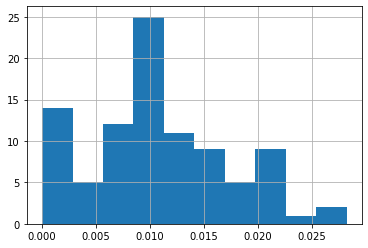

In [17]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [65]:
df_train = df_train[selected_feat]

In [66]:
X_train, X_test, y_train, y_test= normalize_and_split(df_train)

## Modele o domyślnych hiperparametrach:

In [67]:
def trainModel(model, X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)    
    predictions=model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions,average='micro')
    precision = precision_score(y_test, predictions,average='micro')
    f1 = f1_score(y_test, predictions, average='micro')
    auc = roc_auc_score(y_test,predictions)
    errorrate = 1 - accuracy_score(y_test, predictions)
    
    print('accuracy: ', accuracy)
    print('error rate', errorrate)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print('auc: ', auc)
    print('cross_validation: ',np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')))
    print(classification_report(y_test, predictions))
    
    plot_learning_curve(model, X_test, y_test, scoring='roc_auc');    
    plt.show()

### 1. Decision Tree

accuracy:  0.9532122905027933
error rate 0.046787709497206675
recall:  0.9532122905027933
precision:  0.9532122905027933
f1_micro:  0.9532122905027933
auc:  0.5975123909906519
cross_validation:  0.949419019104648
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1386
           1       0.24      0.22      0.23        46

    accuracy                           0.95      1432
   macro avg       0.61      0.60      0.60      1432
weighted avg       0.95      0.95      0.95      1432



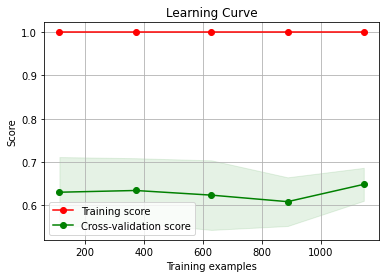

In [21]:
modelDT = DecisionTreeClassifier()

trainModel(modelDT, X_train, y_train, X_test, y_test)

### 2. Random Forest

accuracy:  0.9720670391061452
error rate 0.027932960893854775
recall:  0.9720670391061452
precision:  0.9720670391061452
f1_micro:  0.9720670391061452
auc:  0.5967438358742707
cross_validation:  0.9676753635585971
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.75      0.20      0.31        46

    accuracy                           0.97      1432
   macro avg       0.86      0.60      0.65      1432
weighted avg       0.97      0.97      0.96      1432



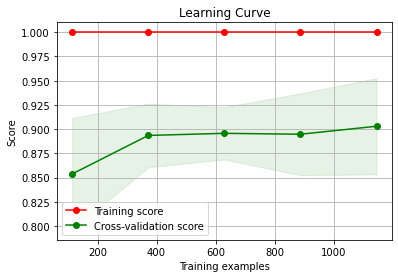

In [22]:
modelRF = RandomForestClassifier()

trainModel(modelRF, X_train, y_train, X_test, y_test)

### 3. SVC (Support Vector Machine)

accuracy:  0.9678770949720671
error rate 0.03212290502793291
recall:  0.9678770949720671
precision:  0.9678770949720671
f1_micro:  0.9678770949720671
auc:  0.5
cross_validation:  0.9676753635585971
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1386
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1432
   macro avg       0.48      0.50      0.49      1432
weighted avg       0.94      0.97      0.95      1432



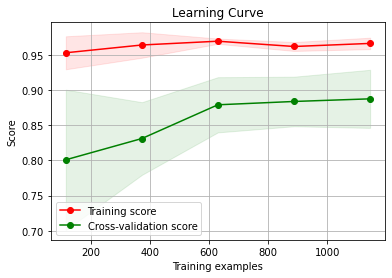

In [23]:
modelSVC = SVC()

trainModel(modelSVC, X_train, y_train, X_test, y_test)

## Tuning hiperparametrów każdego z modeli:

In [24]:
def gridSearch(model,grid, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    result = grid_search.fit(X, y)
    print('Best score (gridSearch): %s' % result.best_score_)
    print('Best hyperparameters: %s' % result.best_params_)
    return

In [25]:
def randomSearch(model,grid, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    random_search = RandomizedSearchCV(estimator=model, param_distributions = grid, n_iter = 70, n_jobs=-1, cv=cv, scoring='accuracy', random_state=123)
    result = random_search.fit(X, y)
    print('Best score (randomSearch): %s' % result.best_score_)
    print('Best hyperparameters: %s' % result.best_params_)
    return 

### 1. Decision Tree

In [26]:
max_depth=[3,5,10,20]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
grid = {'max_features' : max_features,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'splitter': ['best', 'random'],
        "criterion": ["gini", "entropy"]}

In [27]:
gridSearch(modelDT, grid, X_train, y_train)

Best score (gridSearch): 0.9679739029403877
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'splitter': 'random'}


In [28]:
randomSearch(modelDT, grid, X_train, y_train)

Best score (randomSearch): 0.9678738046295466
Best hyperparameters: {'splitter': 'random', 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'entropy'}


### 2. Random Forest

In [29]:
n_estimators = [50,100,200]
max_features = ['auto', 'sqrt']
max_depth = [10,20,40]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = dict(n_estimators=n_estimators,max_features= max_features,max_depth= max_depth,
            min_samples_leaf=min_samples_leaf,bootstrap= bootstrap)

In [30]:
gridSearch(modelRF, grid, X_train, y_train)

Best score (gridSearch): 0.9688718086215627
Best hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}


In [ ]:
randomSearch(modelRF, grid, X_train, y_train)

### 3. SVC

In [32]:
grid = {'C': [0.1, 10, 1000],
        'gamma': [1, 0.01, 0.0001],
        'kernel': ['rbf','poly', 'sigmoid']}

In [33]:
gridSearch(modelSVC, grid, X_train, y_train)

Best score (gridSearch): 0.9676745017427828
Best hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [34]:
randomSearch(modelSVC, grid, X_train, y_train)

Best score (randomSearch): 0.9676745017427828
Best hyperparameters: {'kernel': 'rbf', 'gamma': 1, 'C': 0.1}


## Zobaczmy jak wyglądają wyniki metryk przed i po tuningu:

In [35]:
def compareModels(model,model_grid, model_random, X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)    
    predictions1=model.predict(X_test)
    model_grid.fit(X_train, y_train)    
    predictions2=model_grid.predict(X_test)
    model_random.fit(X_train, y_train)    
    predictions3=model_random.predict(X_test)
    
    accuracy = ["Accuracy", accuracy_score(y_test, predictions1), 
                accuracy_score(y_test, predictions2), 
                accuracy_score(y_test, predictions3)]
    errorrate = ["Error rate", 1-accuracy_score(y_test, predictions1),
                 1-accuracy_score(y_test, predictions2),
                1-accuracy_score(y_test, predictions3)]
    precision = ["Precision", precision_score(y_test, predictions1,average='micro'), 
                 precision_score(y_test, predictions2,average='micro'),
                 precision_score(y_test, predictions3,average='micro')]
    f1 = ["f1", f1_score(y_test, predictions1, average='micro'), 
          f1_score(y_test, predictions2, average='micro'),
          f1_score(y_test, predictions3, average='micro')]
    auc = ["AUC", roc_auc_score(y_test,predictions1),
           roc_auc_score(y_test,predictions2),
           roc_auc_score(y_test,predictions3)]
    cross_val = ["Cross Validation", 
                np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')), 
                np.mean(cross_val_score(model_grid, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')),
                np.mean(cross_val_score(model_random, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise'))]
    
    comparison=[accuracy, errorrate, precision, f1, auc, cross_val]
    return comparison

### 1. Decision Tree

In [36]:
modelDTGrid = DecisionTreeClassifier(criterion= 'entropy',
                                   max_depth= 3,
                                   max_features= 'sqrt',
                                   min_samples_leaf= 2,
                                   splitter= 'random', random_state=123)
modelDTRandom= DecisionTreeClassifier(criterion= 'entropy',
                                   max_depth= 3,
                                   max_features= 'sqrt',
                                   min_samples_leaf= 4,
                                   splitter= 'random', random_state=123)
comparisonDT = compareModels(modelDT, modelDTGrid, modelDTRandom, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonDT, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.952514,0.969274,0.967877
1,Error rate,0.047486,0.030726,0.032123
2,Precision,0.952514,0.969274,0.967877
3,f1,0.952514,0.969274,0.967877
4,AUC,0.597152,0.521739,0.500000
5,Cross Validation,0.951513,0.967675,0.967376


Widzimy, że accuracy, precision, f1 i cross validation zwiększyły wartości po optymalizacji za pomocą grid i random. AUC w obu przypadkach zmalało

### 2. Random Forest

In [79]:
modelRFgrid = RandomForestClassifier(bootstrap= True,
                                     max_depth= 10,
                                     max_features= 'auto',
                                     min_samples_leaf= 2,
                                     n_estimators= 50)
modelRFrandom= RandomForestClassifier(bootstrap= True,
                                     max_depth= 10,
                                     max_features= 'auto',
                                     min_samples_leaf= 4,
                                     n_estimators= 200)
comparisonRF = compareModels(modelRF, modelRFgrid, modelRFrandom, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonRF, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.971369,0.972765,0.970670
1,Error rate,0.028631,0.027235,0.029330
2,Precision,0.971369,0.972765,0.970670
3,f1,0.971369,0.972765,0.970670
4,AUC,0.575365,0.597105,0.564496
5,Cross Validation,0.968871,0.968572,0.968572


Zauważamy, że w przypadku RandomForest wartości metryk są najwyższe przy użyciu modelu z domyślnymi wartościami hiperparametrów 

### 3. SVC

In [80]:
modelSVCgrid = SVC(C= 0.1,
                   gamma= 1,
                   kernel= 'rbf')
modelSVCrandom= SVC(C= 0.1,
                   gamma= 1,
                   kernel= 'rbf')
comparisonSVC = compareModels(modelSVC, modelSVCgrid, modelSVCrandom, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonSVC, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.967877,0.967877,0.967877
1,Error rate,0.032123,0.032123,0.032123
2,Precision,0.967877,0.967877,0.967877
3,f1,0.967877,0.967877,0.967877
4,AUC,0.500000,0.500000,0.500000
5,Cross Validation,0.967675,0.967675,0.967675


W svc nie zmieniły się wartości naszych metryk, co oznacza ze hiperparametry domyślne są najlepsze.

### Podsumowanie
- Początkowo: sprawdziliśmy braki danych, typy zmiennych i ich unikalne wartości, zmieniłyśmy wartości odstające na wartości w odpowiednich kwantylach oraz kierunek korelacji na dodatni, znormalizowałyśmy zmienne ciągłe przy użyciu MinMaxScaler().
- Ograniczyłyśmy ilość zmiennych przez zostawienie najważniejszych kolumn według feature_importance modelu Random Forest.
- Jedynie w przypadku modelu DecisionTree optymalizacja z pomocą grid i random zwiększyła wartości naszych metryk.
- Najbardziej prosperującym modelem jest Random Forest z hiperparamtertami domyślnymi.

# Walidacja
**Autorzy:** Szymon Gut, Jan Krężel

**Wnioski Wstępne**

Wstępna faza preprocessingu na plus. Zespół budujący pamietał o zajęciu się outlierami, zadbał o poprawienie wartości wchodzących z ujemną korelacją oraz, co najważniejsze, zadbał o normalizację MinMax. Jest to przydatne gdyż algorytm SVM dobrze radzi sobie ze znormalizowanymi zmiennymi (z przedziału [-1,1])

Niestety zespół budujący nie zaadresował problemu niezbalansowanego zestawu danych. Tylko mała część firm w zestawie danych zbankrutowała co utrudnia budowę modelu. Jest to szczególnie ważne, ponieważ bardziej nas interesuje poprawne przewidywanie firm na skraju upadku. Ten problem jest szczególnie widoczny przy zastosowaniu SVM, który w implemntacji zespołu budującego nigdy nie przewiduje, że dana firma zbankrutuje (AUC==0.5).

Wpierw wykorzystamy przygotowane przez zespół budujący funkcję do obróki zestawu danych.

Skorzystamy także z już wybranych atrybutów uzyskanych metodą selectFromModel, której użył zespół budujący.

*UWAGA* Obróbka danych powinna być przygotowana za pomocą Pipeline. W szczególności atrybuty są wybierane na podstawie losowo utworzonego lasu klasyfikacyjnego, który za każdym razem daje nieco inne wyniki co sprawia, że dokładna analiza pracy zespołu budującego jest utrudniona.

*UWAGA* Zespół budujący przygotował funkcję ```normalize_and_split```, która jednocześnie normalizuje dane i dzieli ja na dwa zestawy. Nam nie potrzebne jest ponowne dzielenie dlatego musimy wykorzystać tylko część tej funkcji bezpośrednio na stworzonej ramce ```X_val```.

In [70]:
df_val = outliers_to_quantiles(df_val)
df_val = make_corr_positive(df_val)
df_val = df[selected_feat]

In [71]:
X_val = df_val.drop('Bankrupt?', axis=1)
X_val = MinMaxScaler().fit_transform(X_val)

y_val = df_val['Bankrupt?']

### Walidacja wyników

Wpierw sprawdźmy jak modele zespołu budującego sprawdzają się na próbce walidacyjnej

In [73]:
def evaluate_model(model, X_test, y_test, X_val, y_val):
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_test = f1_score(y_test, y_test_pred)
    f1_val = f1_score(y_val, y_val_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    auc_val = roc_auc_score(y_val, y_val_pred)

    eval_df = pd.DataFrame(data={
        'metric': ['accuracy', 'f1 score', 'auc'],
        'test set': [accuracy_test, f1_test, auc_test],
        'validation set': [accuracy_val, f1_val, auc_val]
    })
    return eval_df

**DecisionTree**

DecisionTree Grid Search

In [74]:
evaluate_model(modelDTGrid, X_test, y_test, X_val, y_val)

,metric,test set,validation set
0,accuracy,0.969274,0.968177
1,f1 score,0.083333,0.035556
2,auc,0.521739,0.509015


DecisionTree RandomSearch

In [75]:
evaluate_model(modelDTRandom, X_test, y_test, X_val, y_val)

,metric,test set,validation set
0,accuracy,0.967877,0.967737
1,f1 score,0.000000,0.000000
2,auc,0.500000,0.500000


Na zbiorze testowym mamy minimalnie gorsze wyniki. Największa zmiana widoczna jest dla ```f1 score```, który będąc już i tak niski zmalał ponad dwukrotnie.

**Random Forrest**

In [82]:
evaluate_model(modelRFgrid, X_test, y_test, X_val, y_val)

,metric,test set,validation set
0,accuracy,0.972765,0.967591
1,f1 score,0.315789,0.000000
2,auc,0.597105,0.499924


In [110]:
evaluate_model(modelRFrandom, X_test, y_test, X_val, y_val)

,metric,test set,validation set
0,accuracy,0.970670,0.967737
1,f1 score,0.222222,0.000000
2,auc,0.564496,0.500000


Dla Random Forrest ```f1 score``` spadł do 0. To może oznaczać, że model był przeuczony na zestawie traningiowym i testowym

In [111]:
evaluate_model(modelSVCgrid, X_test, y_test, X_val, y_val)

,metric,test set,validation set
0,accuracy,0.967877,0.967737
1,f1 score,0.000000,0.000000
2,auc,0.500000,0.500000


In [112]:
evaluate_model(modelSVCrandom, X_test, y_test, X_val, y_val)

,metric,test set,validation set
0,accuracy,0.967877,0.967737
1,f1 score,0.000000,0.000000
2,auc,0.500000,0.500000


Dla SVC nie widzimy żadnej wyraźniej zmiany między zestawami. Wynika to głównie z tego, że model nigdy nie przewiduje bankructwa w poprawny sposób.

### Modyfikacje

Zmodyfikujemy lekko funkcje zespołu budującego dodając do niej accuracy balanced, gdyż jak pamiętamy z hw3 nasz zbiór danych jest bardzo mocno nie 
zbalansowany jeśli chodzi o zmienna `bankruptcy`.

In [113]:
from sklearn.metrics import balanced_accuracy_score

In [114]:
def compareModels_val(model,model_grid, model_random, X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)    
    predictions1=model.predict(X_test)
    model_grid.fit(X_train, y_train)    
    predictions2=model_grid.predict(X_test)
    model_random.fit(X_train, y_train)    
    predictions3=model_random.predict(X_test)
    
    accuracy = ["Accuracy", accuracy_score(y_test, predictions1), 
                accuracy_score(y_test, predictions2), 
                accuracy_score(y_test, predictions3)]
    errorrate = ["Error rate", 1-accuracy_score(y_test, predictions1),
                 1-accuracy_score(y_test, predictions2),
                1-accuracy_score(y_test, predictions3)]
    precision = ["Precision", precision_score(y_test, predictions1,average='micro'), 
                 precision_score(y_test, predictions2,average='micro'),
                 precision_score(y_test, predictions3,average='micro')]
    f1 = ["f1", f1_score(y_test, predictions1, average='micro'), 
          f1_score(y_test, predictions2, average='micro'),
          f1_score(y_test, predictions3, average='micro')]
    auc = ["AUC", roc_auc_score(y_test,predictions1),
           roc_auc_score(y_test,predictions2),
           roc_auc_score(y_test,predictions3)]
    balanced_accuracy = ["accuracy_balanced", balanced_accuracy_score(y_test, predictions1), 
          balanced_accuracy_score(y_test, predictions2),
          balanced_accuracy_score(y_test, predictions3)]
    cross_val = ["Cross Validation", 
                np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')), 
                np.mean(cross_val_score(model_grid, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')),
                np.mean(cross_val_score(model_random, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise'))]
    
    comparison=[accuracy, errorrate, precision, f1, auc, balanced_accuracy, cross_val]
    return comparison

Wykorzystamy funkcje zespołu budującego jednak lekko zmienimy parametry zawarte w slowniku `grid`

**Decision tree**
Tutaj zwiększymy liczbę paramatrów dla ```max_depth``` i ```min_samples_leaf```

In [131]:
max_depth=np.arange(3,8)
max_features = ['auto', 'sqrt']
min_samples_leaf = np.logspace(-5, -1, 10)
grid = {'max_features' : max_features,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'splitter': ['best', 'random'],
        "criterion": ["gini", "entropy"]
}

In [126]:
gridSearch(modelDT, grid, X_train, y_train)

Best score (gridSearch): 0.9679742008520269
Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2.782559402207126e-05, 'splitter': 'random'}


Score praktycznie taki sam. Na 6 miejscu po przecinku dopiero zauważamy minimalny wzrost wydajności. Parametry wybrane wcześniej możemy zatem uznać za dobre.

In [132]:
randomSearch(modelDT, grid, X_train, y_train)

Best score (randomSearch): 0.9676747996544222
Best hyperparameters: {'splitter': 'random', 'min_samples_leaf': 0.0016681005372000592, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini'}


Podobnie jak wyżej

**Random Forest**

In [133]:
n_estimators = np.arange(10, 100, 30)
max_features = ['auto', 'sqrt']
max_depth = [5,15,25]
min_samples_leaf = np.logspace(-4,-1, 4)
grid = dict(n_estimators=n_estimators,max_features= max_features,max_depth= max_depth,
            min_samples_leaf=min_samples_leaf)

In [134]:
gridSearch(modelRF, grid, X_train, y_train)

Best score (gridSearch): 0.9687720082223611
Best hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.0001, 'n_estimators': 40}


Uzyskany wynik znów jest porównywalny

In [79]:
n_estimators = np.random.randint(50,200,20)
max_features = ['auto', 'sqrt']
max_depth = np.random.randint(30,50,5)
min_samples_leaf = np.random.randint(1,4,3)
bootstrap = [True, False]
grid = dict(n_estimators=n_estimators,max_features= max_features,max_depth= max_depth,
            min_samples_leaf=min_samples_leaf,bootstrap= bootstrap)

In [80]:
randomSearch(modelRF, grid, X_train, y_train)

Best score (randomSearch): 0.9688712127982839
Best hyperparameters: {'n_estimators': 138, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 38, 'bootstrap': True}


**SVC**

Tutaj przede wszystkim zajmiemy się wagami klas.

In [ ]:
from scipy.stats import uniform

In [141]:
grid = {'C': [0.1,0.5,1],
        'gamma': np.random.uniform(0.1,1,3),
        'class_weight': [None, 'Balanced']}

In [142]:
gridSearch(modelSVC, grid, X_train, y_train)

Best score (gridSearch): 0.9676745017427828
Best hyperparameters: {'C': 0.1, 'class_weight': None, 'gamma': 0.7847284977294021}


In [137]:
grid = {'C': np.random.uniform(0.01,1,15),
        'gamma': np.random.uniform(0.001,1,20),
        'class_weight': [None, 'Balanced']}

In [138]:
randomSearch(modelSVC, grid, X_train, y_train)

Best score (randomSearch): 0.9676745017427828
Best hyperparameters: {'gamma': 0.6047561366591592, 'class_weight': None, 'C': 0.1294821318036346}


In [159]:
weights = [{0:1, 1:i/4} for i in range(100)]
f1_scores = np.empty(100)
for i, weight in enumerate(weights):
    model = SVC(class_weight=weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    # używamy test a nie val, ponieważ nie sprawdzamy poprawności modelu zbudowanego 
    # a jedynie proponujemy poprawki dla zespołu budującego
    f1_scores[i] = f1_score(y_test, y_pred)

np.max(f1_scores)

0.4038461538461538

In [162]:
np.argmax(f1_scores)/4

8.25

Dla stosunku wag 1:8.25 udało nam się osiągnąć ```f1 score``` o wysokości 0.404. Jest to wynik daleki od idealnego, ale dużo lepiej pasuje do naszych oczekiwań co do modelu.

### Porównanie metryk po i przed tuningiem

**Decision Tree**


In [166]:
modelDTGrid_val = DecisionTreeClassifier(criterion= 'gini',
                                   max_depth= 3,
                                   max_features= 'auto',
                                   min_samples_leaf= 2.8e-5,
                                   splitter= 'random', random_state=123)
modelDTRandom_val = DecisionTreeClassifier(criterion= 'gini',
                                   max_depth= 3,
                                   max_features= 'sqrt',
                                   min_samples_leaf= 0.00157,
                                   splitter= 'random', random_state=123)
comparisonDT = compareModels_val(modelDT, modelDTGrid_val, modelDTRandom_val, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonDT, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.953212,0.969274,0.967877
1,Error rate,0.046788,0.030726,0.032123
2,Precision,0.953212,0.969274,0.967877
3,f1,0.953212,0.969274,0.967877
4,AUC,0.671074,0.521739,0.500000
5,accuracy_balanced,0.671074,0.521739,0.500000
6,Cross Validation,0.952709,0.967975,0.967675


### Random Forest

In [167]:
modelRFgrid_val = RandomForestClassifier(bootstrap= True,
                                     max_depth= 50,
                                     max_features= 'sqrt',
                                     min_samples_leaf= 1e-4,
                                     n_estimators= 40)
modelRFrandom_val = RandomForestClassifier(bootstrap= True,
                                     max_depth= 38,
                                     max_features= 'auto',
                                     min_samples_leaf= 3,
                                     n_estimators= 138)
comparisonRF = compareModels_val(modelRF, modelRFgrid_val, modelRFrandom_val, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonRF, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.972067,0.972765,0.972067
1,Error rate,0.027933,0.027235,0.027933
2,Precision,0.972067,0.972765,0.972067
3,f1,0.972067,0.972765,0.972067
4,AUC,0.575726,0.586596,0.586235
5,accuracy_balanced,0.575726,0.586596,0.586235
6,Cross Validation,0.967674,0.966478,0.967973


### SVC

In [168]:
modelSVCgrid_val = SVC(C= 0.1,
                   gamma= 0.7847,
                   class_weight= {0:1, 1:8.25},
                   kernel= 'rbf')
modelSVCrandom_val = SVC(C= 0.9676745017427828,
                   gamma= 0.6047561366591592,
                   class_weight= {0:1, 1:8.25},
                   kernel= 'rbf')
comparisonSVC = compareModels_val(modelSVC, modelSVCgrid_val, modelSVCrandom_val, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonSVC, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.967877,0.968575,0.945531
1,Error rate,0.032123,0.031425,0.054469
2,Precision,0.967877,0.968575,0.945531
3,f1,0.967877,0.968575,0.945531
4,AUC,0.500000,0.573922,0.740668
5,accuracy_balanced,0.500000,0.573922,0.740668
6,Cross Validation,0.967675,0.965884,0.942241


Dla randomSearch widzimy największą różnicę jeśli chodzi o AUC. Oryginalnie model nie radził sobie z niezbalansowanym zbiorem danych. Po lekkich zmianach radzi sobie lepiej chociaż nadal nie idealnie (ani blisko perfekcji)

Patrząc na accuracy możemy odnieść złudną nadzieje, że nasz model jest idealny. Zawsze jednak warto jednak zwrócić uwagę na `accuracy_balanced_score` albo na `AUC`.

### Confusion Matrix

Na sam koniec możemy dodać confusion matrix, żeby zobaczyć jak zachowują się modele zespołu budującego

In [169]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Decision Tree

### DT dla domyślnych parametrów

<function matplotlib.pyplot.show(close=None, block=None)>

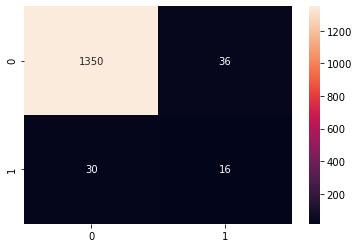

In [171]:
modelDT.fit(X_train, y_train)
y_pred = modelDT.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

### Grid Search

<function matplotlib.pyplot.show(close=None, block=None)>

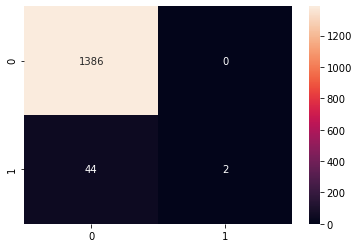

In [173]:
modelDTGrid.fit(X_train, y_train)
y_pred = modelDTGrid.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

### Random Search

<function matplotlib.pyplot.show(close=None, block=None)>

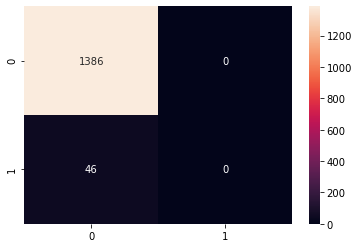

In [175]:
modelDTRandom_val.fit(X_train, y_train)
y_pred = modelDTRandom.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

## Random Forest

### Parametry domyślne

<function matplotlib.pyplot.show(close=None, block=None)>

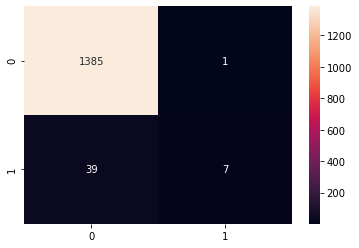

In [177]:
modelRF.fit(X_train, y_train)
y_pred = modelRF.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

### Grid Search

<function matplotlib.pyplot.show(close=None, block=None)>

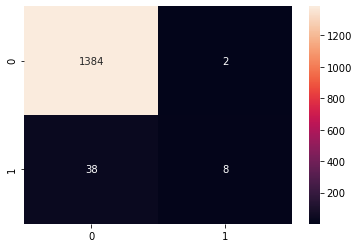

In [178]:
modelRFgrid.fit(X_train, y_train)
y_pred = modelRFrandom_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

### Random Search

<function matplotlib.pyplot.show(close=None, block=None)>

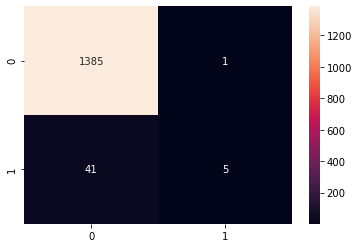

In [179]:
modelRFrandom.fit(X_train, y_train)
y_pred = modelRFrandom.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

## SVC

### Domyślne parametry

<function matplotlib.pyplot.show(close=None, block=None)>

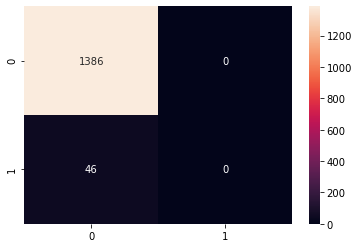

In [180]:
modelSVC.fit(X_train, y_train)
y_pred = modelSVC.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

### Grid Search

<function matplotlib.pyplot.show(close=None, block=None)>

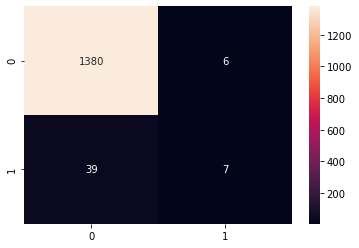

In [181]:
modelSVCgrid.fit(X_train, y_train)
y_pred = modelSVCgrid_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

### Random Search

<function matplotlib.pyplot.show(close=None, block=None)>

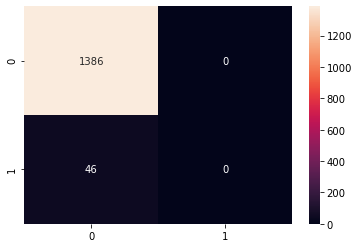

In [182]:
modelSVCrandom.fit(X_train, y_train)
y_pred = modelSVCrandom.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

Sprawdźmy jeszcze jak wygląda Confusion Matrix dla lepiej dobranych wag

<function matplotlib.pyplot.show(close=None, block=None)>

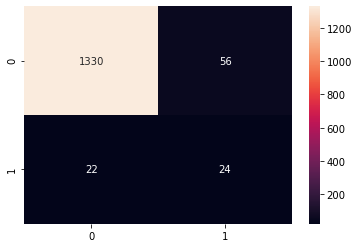

In [183]:
modelSVCrandom_val.fit(X_train, y_train)
y_pred = modelSVCrandom_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show

Tak jak zostało to stwierdzone wyżej nasz model lepiej przewiduje bankrutów jednak nadal ```recall``` dla tego typu predykcji to nadal około 50%.

Zaleca się dogłębsza hiperparametryzacja w celu predykcji bankructwa.

### Wnioski końcowe

Po dogłębnej analizie pracy zespołu budującego dochodzimy do następujących wniosków.

- Początkowa faza budowy modelu jest poprawna
    - Zespół budujący odpowiednio przekształcił i podzielił dane przygotowując je do dalszej pracy
    - Aby ułatwić pracę zespołu budującego i walidującego zespoł budujący powinien był zastosować Pipeline do obróbki danych
    - ***Drobna uwaga*** W przypadku braku uzycia Pipeline funkcja normalize_and_split powinna być rozdzielona  
- Zespół budujący dobrze wykorzystał GridSearch oraz RandomSearch do optymalizacji hiperparametrów
    - Poprawne i dogłębne przeszukiwanie różnego typu hiperparametrów
    - W szczególności dobre było zastosowanie dogłębnej walidacji krzyżowej i przygotowanie funkcji zajmującej się przeszukiwaniem
- Zespół budujący nie uwzględnił w budowie modelu braku balansu obserwacji
    - Wagi obserwacji nie powinny być sobie równe w takim zestawie danych
    - Zespół zbytnio skupił się na optymalizacji ```f1 score``` i ```accuracy```,  
    które w tego typu zestawach mają tendecję do przekłamywania faktycznej użyteczności modelu
    - Ponadto zaleca się używanie Confusion Matrix, które od razu w sposób jednoznaczny uwidacznia problemy z brakiem balansu w danych
